# Predict Future Sales
## Final project for "How to win a data science competition" Coursera course

In [1]:
import os
import gc

import pandas as pd
import numpy as np

from itertools import product

In [2]:
import lightgbm as lgb

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score, mean_squared_error  
from tqdm import tqdm_notebook

import statsmodels.api as sm

from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

/Users/pilotwave/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

# For Memory Downcast

In [5]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
    return props, NAlist

# Read Data Files

In [6]:
DATA_FOLDER = 'data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))

# EDA

In [7]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [8]:
# Print Head
monthly_sales.head(20)

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              0       32       03.01.2013  31.01.2013      221.0          6.0
                       33       03.01.2013  28.01.2013      347.0          3.0
                       35       31.01.2013  31.01.2013      247.0          1.0
                       43       31.01.2013  31.01.2013      221.0          1.0
                       51       13.01.2013  31.01.2013      128.5          2.0
                       61       10.01.2013  10.01.2013      195.0          1.0
                       75       17.01.2013  17.01.2013       76.0          1.0
                       88       16.01.2013  16.01.2013       76.0          1.0
                       95       06.01.2013  06.01.2013      193.0          1.0
                       96       10.01.2013  10.01.2013       70.0          1.0
                       98       04.01.2013  31.01.2013      268.0         25.0
                       111      17.01.2013  17.01.2013       89.0          1.0
                       149      11.01.2013  28.01.2013       99.0          3.0
                       151      16.01.2013  16.01.2013       75.0          1.0
                       153      09.01.2013  09.01.2013      258.0          1.0
                       198      10.01.2013  10.01.2013      112.0          1.0
                       210      05.01.2013  25.01.2013      118.0          2.0
                       282      04.01.2013  04.01.2013      109.0          1.0
                       306      22.01.2013  22.01.2013       59.0          1.0
                       351      21.01.2013  21.01.2013       89.0          1.0

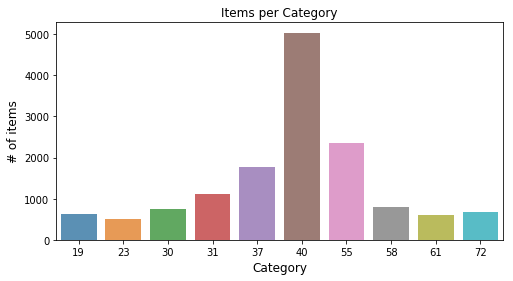

In [9]:
# number of items per cat 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id', ascending=False)
x=x.iloc[0:10].reset_index()

# plot
plt.figure(figsize=(8, 4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

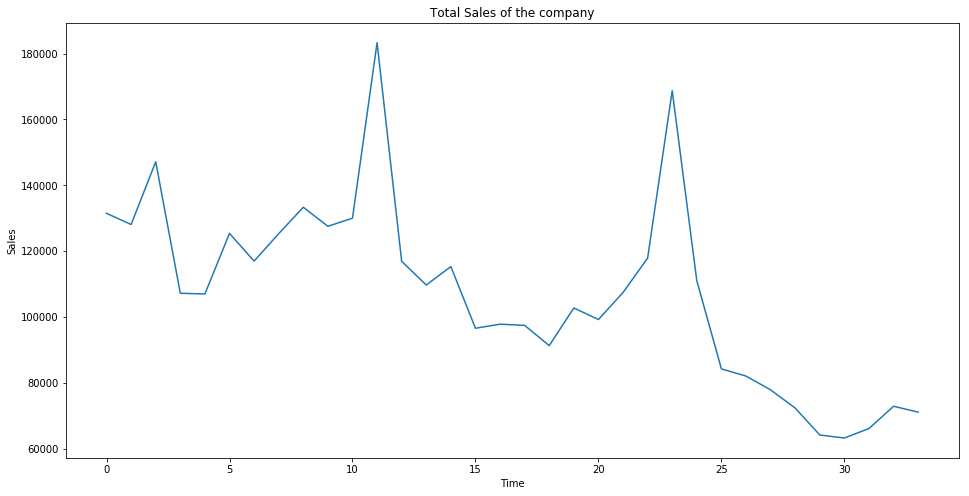

In [10]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16, 8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

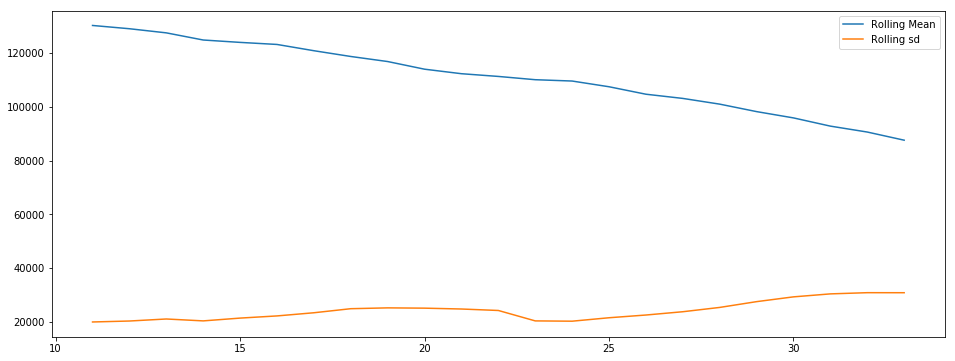

In [11]:
plt.figure(figsize=(16, 6))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean');
plt.plot(ts.rolling(window=12, center=False).std(), label='Rolling sd');
plt.legend();

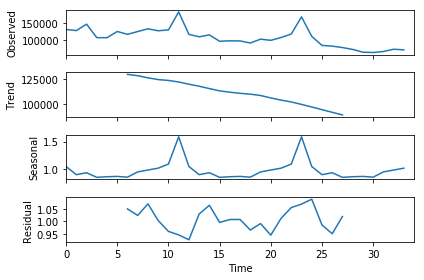

In [12]:
# Multiplicative model
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
fig = res.plot()

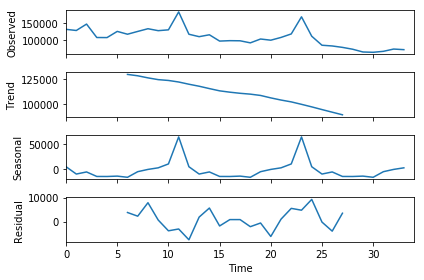

In [13]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="additive")
fig = res.plot()

# Get Feature Matrix

In [14]:
# Add date_block_num for test with value 34 (next month)
test['date_block_num'] = 34

In [15]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=1000]

In [16]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data, NAS = reduce_mem_usage(all_data)
del grid, gb, sales 
gc.collect();

/Users/pilotwave/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


# Mean Encoding Expansion

In [17]:
globalmean = all_data.target.mean()

In [18]:
cum_sum = all_data.groupby('item_id')['target'].cumsum()-all_data['target']
cum_cnt = all_data.groupby('item_id').cumcount()

all_data['item_target_enc'] = cum_sum/cum_cnt
all_data['item_target_enc'].fillna(globalmean, inplace=True)

encoded_feature = all_data['item_target_enc'].values
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.5140161856394935


In [19]:
cum_sum = all_data.groupby('shop_id')['target'].cumsum()-all_data['target']
cum_cnt = all_data.groupby('shop_id').cumcount()

all_data['shop_target_enc'] = cum_sum/cum_cnt
all_data['shop_target_enc'].fillna(globalmean, inplace=True)

encoded_feature = all_data['shop_target_enc'].values
corr = np.corrcoef(all_data['target'].values, encoded_feature)[0][1]
print(corr)

0.07401277017271103


# Create Lag Features

In [20]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
    # Merge lag feature with test data
    test = pd.merge(test, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect();

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,item_target_enc,shop_target_enc,item_target_enc_lag_1,shop_target_enc_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_lag_2,shop_target_enc_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_lag_3,shop_target_enc_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3,item_target_enc_lag_4,shop_target_enc_lag_4,target_lag_4,target_item_lag_4,target_shop_lag_4,item_target_enc_lag_5,shop_target_enc_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_lag_12,shop_target_enc_lag_12,target_lag_12,target_item_lag_12,target_shop_lag_12
0,59,22154,0,1,2017,18,0.334076,0.334076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59,2552,0,0,2017,0,0.334076,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59,2554,0,0,2017,1,0.334076,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,59,2555,0,0,2017,2,0.334076,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59,2564,0,0,2017,5,0.334076,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
test.head()

,ID,shop_id,item_id,date_block_num,item_target_enc_lag_1,shop_target_enc_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_lag_2,shop_target_enc_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_lag_3,shop_target_enc_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3,item_target_enc_lag_4,shop_target_enc_lag_4,target_lag_4,target_item_lag_4,target_shop_lag_4,item_target_enc_lag_5,shop_target_enc_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_lag_12,shop_target_enc_lag_12,target_lag_12,target_item_lag_12,target_shop_lag_12
0,0,5,5037,34,1.974961,0.191096,0.0,25.0,1052.0,2.026981,0.191050,1.0,110.0,1092.0,2.007246,0.187935,3.0,119.0,1294.0,2.008351,0.187475,1.0,54.0,991.0,2.032051,0.188183,1.0,105.0,954.0,2.372093,0.178553,1.0,65.0,1445.0
1,1,5,5320,34,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,2,5,5233,34,1.673469,0.191485,1.0,42.0,1052.0,1.758065,0.191115,3.0,80.0,1092.0,1.661836,0.187909,1.0,150.0,1294.0,1.477612,0.190526,0.0,37.0,991.0,1.463415,0.188209,2.0,119.0,954.0,0.000000,0.000000,0.0,0.0,0.0
3,3,5,5232,34,1.119658,0.191486,0.0,28.0,1052.0,1.394366,0.191116,0.0,48.0,1092.0,1.666667,0.187905,1.0,65.0,1294.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,4,5,5268,34,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [23]:
# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')

test = pd.merge(test, item_category_mapping, how='left', on='item_id')

In [24]:
test, NAs = reduce_mem_usage(test)

In [25]:
all_data, NAs = reduce_mem_usage(all_data)

# Feature Interactions

In [26]:
## Add lag feature differences (feature interaction)
for i in [2, 3, 4, 5]:
    fname = '_lag' + str(i-1) + '_lag' + str(i)
    lag1 = '_lag_' + str(i-1)
    lag2 = '_lag_' + str(i)
    all_data['target' + fname] = all_data['target' + lag1] - all_data['target' + lag2]
    test['target' + fname] = test['target' + lag1] - test['target' + lag2]
    all_data['target_item' + fname] = all_data['target_item' + lag1] - all_data['target_item' + lag2]
    test['target_item' + fname] = test['target_item' + lag1] - test['target_item' + lag2]
    all_data['target_shop' + fname] = all_data['target_shop' + lag1] - all_data['target_shop' + lag2]
    test['target_shop' + fname] = test['target_shop' + lag1] - test['target_shop' + lag2]

In [27]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
fit_cols.append('item_category_id')

# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']

In [28]:
all_data, NAs = reduce_mem_usage(all_data)

# Feature Importance: SVD, PCA

In [29]:
X = all_data.drop(to_drop_cols, axis=1)

In [30]:
## Standardize the data
X_std = StandardScaler().fit_transform(X)

In [31]:
## Get Covariance matrix

cov_mat = np.cov(X_std.T)
print('Covariance matrix shape', cov_mat.shape)

Covariance matrix shape (45, 45)


In [32]:
## Getting eigen vectors and eigen values
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [33]:
print('\nEigenvalues \n%s' %eig_vals)


Eigenvalues 
[ 1.12299029e+01  8.41018339e+00  2.53874034e+00  2.45246472e+00
  2.06189454e+00  1.85312069e+00  1.53284263e+00  1.44839524e+00
  1.18233668e+00  1.15385123e+00  1.16106804e+00  1.07869357e+00
  9.89271384e-01  1.00251962e+00  8.64793520e-01  8.30424915e-01
  7.69733297e-01  7.16731184e-01  5.79841316e-01  5.03818930e-01
  4.34186419e-01  3.31656067e-01  2.95062256e-01  3.02334414e-01
  2.77292387e-01  2.34991674e-01  1.83961285e-01  1.09461115e-01
  9.87634056e-02  8.73289830e-02  6.06002229e-02  5.79910472e-02
  2.53185723e-02  2.83114527e-02  4.10762211e-02  3.36970748e-02
  3.73462235e-02  6.07907167e-14  3.09656172e-14 -1.10624340e-14
 -8.38102525e-15  1.56638221e-14  1.03865202e-14  6.39250734e-15
 -2.60193845e-15]


In [34]:
## Making sure eigen vectors have a norm of 1
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev), decimal=2)
print('Everything ok!')

Everything ok!


In [35]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
11.2299029300703
8.410183390052927
2.538740341184435
2.452464720412939
2.061894544978019
1.8531206924495818
1.532842633567943
1.4483952372990696
1.1823366796905501
1.161068044149321
1.1538512317467606
1.0786935682663288
1.002519624131167
0.989271383563976
0.8647935195993379
0.8304249148485281
0.7697332973880462
0.7167311843206887
0.5798413161541918
0.5038189301744337
0.4341864191159332
0.3316560667184496
0.30233441418401186
0.29506225558978794
0.2772923867470832
0.23499167409046007
0.18396128486735644
0.10946111540457443
0.09876340557371342
0.08732898296752391
0.06060022285559854
0.05799104721531474
0.04107622111949114
0.037346223539176986
0.03369707480829582
0.02831145265339608
0.025318572290944474
6.079071670478364e-14
3.09656171816135e-14
1.5663822102807473e-14
1.1062433955107707e-14
1.0386520249460921e-14
8.381025249834579e-15
6.392507343317325e-15
2.601938453760397e-15


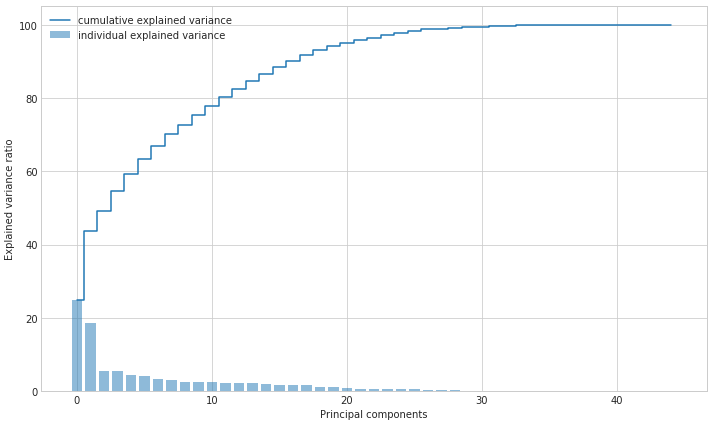

In [36]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

num_eig = len(eig_pairs)

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 6))

    plt.bar(range(num_eig), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(num_eig), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [37]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(num_eig,1),
                      eig_pairs[1][1].reshape(num_eig,1)))

In [38]:
X_2 = X_std.dot(matrix_w)

In [39]:
X_2 = pd.DataFrame(X_2, columns=['PCA_1', 'PCA_2'])

In [40]:
all_data['PCA_1'] = X_2['PCA_1']
all_data['PCA_2'] = X_2['PCA_2']

In [41]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,item_target_enc,shop_target_enc,item_target_enc_lag_1,shop_target_enc_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_lag_2,shop_target_enc_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_lag_3,shop_target_enc_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3,item_target_enc_lag_4,shop_target_enc_lag_4,...,item_target_enc_lag_5,shop_target_enc_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_lag_12,shop_target_enc_lag_12,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_lag1_lag2,target_item_lag1_lag2,target_shop_lag1_lag2,target_lag2_lag3,target_item_lag2_lag3,target_shop_lag2_lag3,target_lag3_lag4,target_item_lag3_lag4,target_shop_lag3_lag4,target_lag4_lag5,target_item_lag4_lag5,target_shop_lag4_lag5,PCA_1,PCA_2
4488710,54,10297,12,4,8198,23,0.483516,0.978418,0.408451,0.982407,3,42,10055,0.064516,0.956484,0,2,7978,0.000000,0.000000,0,0,0,0.000000,0.000000,...,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,37,3,40,2077,0,2,7978,0,0,0,0,0,0,0.142908,-0.941879
4488711,54,10296,12,3,8198,17,0.521739,0.978448,0.615385,0.982418,0,24,10055,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,...,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,38,0,24,10055,0,0,0,0,0,0,0,0,0,0.220933,-0.990100
4488712,54,10298,12,14,8198,182,13.299270,0.978469,14.136752,0.982429,21,369,10055,11.935065,0.956472,119,1309,7978,3.166667,0.983269,7,144,6676,0.000000,0.000000,...,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,40,-98,-940,2077,112,1165,1302,7,144,6676,0,0,0,-1.093809,-0.640732
4488713,54,10300,12,3,8198,26,3.416058,0.978601,3.829060,0.982648,1,54,10055,3.727273,0.957913,31,361,7978,0.944444,1.006167,0,53,6676,0.000000,0.000000,...,0.000000,0.000000,0,0,0,0.0,0.0,0,0,0,37,-30,-307,2077,31,308,1302,0,53,6676,0,0,0,-3.646182,0.083556
4488714,54,10284,12,1,8198,3,0.133772,0.978622,0.135321,1.014041,0,4,10055,0.138889,0.956061,0,3,7978,0.151335,0.988101,0,5,6676,0.166065,0.994672,...,0.160173,1.013197,0,10,7792,0.0,0.0,0,0,0,57,0,1,2077,0,-2,1302,0,2,64385,0,-7,35,-3.261858,-0.038416


# Hyeper-parameter Optimization

In [44]:
!pip install networkx==1.11 # Optional

In [ ]:
def score(params):
    print("Training with params : ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    
    model = LGBMRegressor(**params)
    
    X_train = all_data.loc[dates <  33].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == 33].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  33, 'target'].values
    y_test =  all_data.loc[dates == 33, 'target'].values
    
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(preds, y_test))
    print(rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
'''
def lgbm_objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree'])
    }
    reg = lgbm.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.1,
        **params
    )
    score = cross_val_score(reg, x_train, y_train, scoring=MSE_scorer(), cv=StratifiedKFold()).mean()
    return score

lgbm_space = {
    'max_depth': hp.quniform('max_depth', 8, 128, 2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
}

lgbm_best = fmin(fn=lgbm_objective,
            space=lgbm_space,
            algo=tpe.suggest,
            max_evals=10)
'''

def optimize(#trials,
            random_state=3141):
    space = {
                'feature_fraction': hp.uniform('feature_fraction', 0.25, 1.25, 0.25),
                'metric': 'rmse',
                'nthread':4, 
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1**7, 2**7, 1**6), 
                'bagging_fraction': hp.uniform('bagging_fraction', 0.25, 1.25, 0.25), 
                'learning_rate': hp.uniform('learning_rate', 0.01, 0.03, 0.005), 
                'objective': 'mse', 
                'bagging_seed': hp.quniform('bagging_seed', 1**7, 2**7, 1**6), 
                'num_leaves': hp.quniform('num_leaves', 1**7, 2**7, 1**6),
                'bagging_freq':hp.uniform('bagging_freq', 0.8, 1.3, 0.1),
                'verbose':0 
            }

    best = fmin(score, space, algo=tpe.suggest, 
                #trials=trials, 
                max_evals=250)
    
    return best

In [ ]:
#Trials object where the history of search will be stored
#trials = Trials()
best_params = optimize()

# Cross-Validation Model Training

In [42]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [43]:
all_data.target.describe()

count    6.425094e+06
mean     3.242449e-01
std      3.504246e+00
min     -5.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.644000e+03
Name: target, dtype: float64

In [44]:
# Clipping to 40 seems to improve RMSE score.
# Tune this value to further improve score?
all_data['target'] = all_data.target.clip(lower=-1, upper=40)

In [45]:
all_data.target.describe()

count    6.425094e+06
mean     2.992826e-01
std      1.435029e+00
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+01
Name: target, dtype: float64

In [ ]:
def clip(x):
    if x>40:
        return 40
    elif x<0:
        return 0
    else:
        return x
all_data['item_cnt_day'] = all_data.apply(lambda x: clip(x['item_cnt_day']),axis=1)

In [ ]:
model = lgb.LGBMRegressor(**best_params)

In [46]:
model = lgb.LGBMRegressor(n_jobs=-1, metric='rmse', objective='mse')

In [47]:
pca = ['PCA_1','PCA_2']
all_data.drop(pca, axis=1, inplace=True)

In [48]:
# Moving window validation scheme.
# On each iteration, use last month for validation
validation_months = [33, 32, 31, 30, 29]

for last_month in validation_months:
    # Split train and validation data
    dates_train = dates[dates <  last_month]
    dates_test  = dates[dates == last_month]

    X_train = all_data.loc[dates <  last_month].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == last_month].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  last_month, 'target'].values
    y_test =  all_data.loc[dates == last_month, 'target'].values
    
    model.fit(X_train, y_train)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    ## R2 and RMSE score for each validation fold
    print('Month {0:d} Test R-2: {1:f}'.format(last_month, r2_score(y_test, pred_test)))
    print('Month {0:d} Test RMSE {1:f}'.format(last_month, np.sqrt(mean_squared_error(y_test, pred_test))))
    
del dates_train, dates_test, X_train, X_test, y_train, y_test, pred_train, pred_test
gc.collect()

Month 33 Test R-2: 0.330457
Month 33 Test RMSE 1.143633
Month 32 Test R-2: 0.414433
Month 32 Test RMSE 1.126102
Month 31 Test R-2: 0.528701
Month 31 Test RMSE 0.840897
Month 30 Test R-2: 0.549552
Month 30 Test RMSE 0.765841
Month 29 Test R-2: 0.505153
Month 29 Test RMSE 0.883864


5077

# GBM Feature Importance

In [ ]:
# Feature importances for LightGBM
lgb_importances = pd.DataFrame(model.feature_importance, columns=['Importance'])
lgb_importances['Feature Name'] = feature_names
lgb_importances.sort_values(by=['Importance'], inplace=True)
lgb_importances = lgb_importances[['Feature Name', 'Importance']].set_index('Feature Name')
lgb_importances.head(20)

In [ ]:
ax = lgb_importances.plot(kind='barh', figsize=(30, 30), fontsize=20)
plt.show()

# Submission Preparation

In [52]:
## Take all train data
X_train_all = all_data.drop(to_drop_cols, axis=1)
y_train_all = all_data.target.values

In [53]:
y = pd.DataFrame(y_train_all)

In [54]:
test.head()

,ID,shop_id,item_id,date_block_num,item_target_enc_lag_1,shop_target_enc_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_lag_2,shop_target_enc_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_lag_3,shop_target_enc_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3,item_target_enc_lag_4,shop_target_enc_lag_4,target_lag_4,target_item_lag_4,target_shop_lag_4,item_target_enc_lag_5,shop_target_enc_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_lag_12,shop_target_enc_lag_12,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_lag1_lag2,target_item_lag1_lag2,target_shop_lag1_lag2,target_lag2_lag3,target_item_lag2_lag3,target_shop_lag2_lag3,target_lag3_lag4,target_item_lag3_lag4,target_shop_lag3_lag4,target_lag4_lag5,target_item_lag4_lag5,target_shop_lag4_lag5
0,0,5,5037,34,1.974961,0.191096,0,25,1052,2.026981,0.191050,1,110,1092,2.007246,0.187935,3,119,1294,2.008351,0.187475,1,54,991,2.032051,0.188183,1,105,954,2.372093,0.178553,1,65,1445,19,-1,65451,65496,-2,-9,65334,2,65,303,0,-51,37
1,1,5,5320,34,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5,5233,34,1.673469,0.191485,1,42,1052,1.758065,0.191115,3,80,1092,1.661836,0.187909,1,150,1294,1.477612,0.190526,0,37,991,1.463415,0.188209,2,119,954,0.000000,0.000000,0,0,0,19,-2,65498,65496,2,-70,65334,1,113,303,-2,-82,37
3,3,5,5232,34,1.119658,0.191486,0,28,1052,1.394366,0.191116,0,48,1092,1.666667,0.187905,1,65,1294,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,23,0,65516,65496,-1,-17,65334,1,65,1294,0,0,0
4,4,5,5268,34,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0


In [55]:
test.sort_values('ID')

,ID,shop_id,item_id,date_block_num,item_target_enc_lag_1,shop_target_enc_lag_1,target_lag_1,target_item_lag_1,target_shop_lag_1,item_target_enc_lag_2,shop_target_enc_lag_2,target_lag_2,target_item_lag_2,target_shop_lag_2,item_target_enc_lag_3,shop_target_enc_lag_3,target_lag_3,target_item_lag_3,target_shop_lag_3,item_target_enc_lag_4,shop_target_enc_lag_4,target_lag_4,target_item_lag_4,target_shop_lag_4,item_target_enc_lag_5,shop_target_enc_lag_5,target_lag_5,target_item_lag_5,target_shop_lag_5,item_target_enc_lag_12,shop_target_enc_lag_12,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_lag1_lag2,target_item_lag1_lag2,target_shop_lag1_lag2,target_lag2_lag3,target_item_lag2_lag3,target_shop_lag2_lag3,target_lag3_lag4,target_item_lag3_lag4,target_shop_lag3_lag4,target_lag4_lag5,target_item_lag4_lag5,target_shop_lag4_lag5
0,0,5,5037,34,1.974961,0.191096,0,25,1052,2.026981,0.191050,1,110,1092,2.007246,0.187935,3,119,1294,2.008351,0.187475,1,54,991,2.032051,0.188183,1,105,954,2.372093,0.178553,1,65,1445,19,-1,65451,65496,-2,-9,65334,2,65,303,0,-51,37
1,1,5,5320,34,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,55,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5,5233,34,1.673469,0.191485,1,42,1052,1.758065,0.191115,3,80,1092,1.661836,0.187909,1,150,1294,1.477612,0.190526,0,37,991,1.463415,0.188209,2,119,954,0.000000,0.000000,0,0,0,19,-2,65498,65496,2,-70,65334,1,113,303,-2,-82,37
3,3,5,5232,34,1.119658,0.191486,0,28,1052,1.394366,0.191116,0,48,1092,1.666667,0.187905,1,65,1294,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,23,0,65516,65496,-1,-17,65334,1,65,1294,0,0,0
4,4,5,5268,34,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0
5,5,5,5039,34,1.613459,0.191095,1,29,1052,1.657673,0.191054,1,93,1092,1.621377,0.187952,0,107,1294,1.609603,0.190532,0,41,991,1.611111,0.188070,0,84,954,1.806202,0.178563,0,45,1445,23,0,65472,65496,1,-14,65334,0,66,303,0,-43,37
6,6,5,5041,34,3.866667,0.191099,2,62,1052,5.517241,0.191037,3,249,1092,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,20,-1,65349,65496,3,249,1092,0,0,0,0,0,0
7,7,5,5046,34,1.026071,0.191562,0,12,1052,1.097760,0.191261,0,9,1092,1.177778,0.187955,0,13,1294,1.312997,0.190599,0,24,991,1.338798,0.189418,1,21,954,0.407407,0.183343,1,29,1445,55,0,3,65496,0,-4,65334,0,-11,303,-1,3,37
8,8,5,5319,34,3.122905,0.191740,0,26,1052,3.354379,0.191045,3,43,1092,3.571111,0.187953,2,51,1294,4.031830,0.187445,3,47,991,4.117486,0.188051,4,56,954,6.333333,0.183396,5,270,1445,55,-3,65519,65496,1,-8,65334,-1,4,303,-1,-9,37
9,9,5,5003,34,1.160000,0.191487,0,95,1052,0.172414,0.191146,0,12,1092,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,20,0,83,65496,0,12,1092,0,0,0,0,0,0


In [56]:
test_id = test.pop('ID')
test.drop('date_block_num', axis=1, inplace=True)

In [57]:
model.fit(X_train_all, y_train_all)

pred_train_all = model.predict(X_train_all)
pred_test = model.predict(test)

## R2 and RMSE score for each validation fold
print('Train R-2: {0:f}'.format(r2_score(y_train_all, pred_train_all)))
print('Train RMSE {0:f}'.format(np.sqrt(mean_squared_error(y_train_all, pred_train_all))))

Train R-2: 0.518307
Train RMSE 0.995969


In [58]:
pred_test = list(map(lambda x: min(20, max(x, 0)), list(pred_test)))

In [59]:
test_submit = pd.DataFrame({'ID': test_id, 'item_cnt_month': pred_test})
print(test_submit.shape)
test_submit.to_csv('submissions/submission.csv', index=False)
test_submit.head()

(214200, 2)


,ID,item_cnt_month
0,0,0.000000
1,1,0.220460
2,2,0.000000
3,3,0.000000
4,4,2.778054
